In [1]:
from langchain_community import vectorstores
from langchain_community.vectorstores import Chroma
from langchain_groq import ChatGroq
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from pydantic import BaseModel , Field
from langchain.prompts import PromptTemplate
from typing import TypedDict, Annotated, Sequence, Optional
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_core.tools import tool
import os
from dotenv import load_dotenv

load_dotenv()

api_key = "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"
print(api_key)



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


In [2]:
# from langchain.tools import tool
# import yfinance as yf

# @tool
# # Convenience function that matches your original signature
# def YahooFinanceTool(ticker: str) -> str:
#     """
#     Fetches financial data for a given ticker symbol.
    
#     Args:
#         ticker (str): The ticker symbol of the company (e.g., "AAPL" for Apple).
        
#     Returns:
#         str: A summary of the financial data including current price, market cap, and other key metrics.
#     """
#     tool = YahooFinanceTool()
#     return tool.get_stock_data(ticker)

In [3]:
from langchain.output_parsers import PydanticOutputParser

class AgentParser(BaseModel):
    Topic: str = Field(description="Selected tool for answering the question (e.g., finance_tool or web_tool)")
    Reasoning: str = Field(description="Reason why this tool was selected based on the question")

# Create parser
parser = PydanticOutputParser(pydantic_object=AgentParser)


In [4]:
from typing import TypedDict, Literal
class AgentState(TypedDict):
    question:str
    result: Optional[str]
    tool_type:Literal["YahooFinanceNewsTool", "WebSearch"]
    parser_result:Optional[str]
    is_valid =Optional[str]
    retry_count: int

In [5]:
# !pip install -U duckduckgo-search

# from langchain_community.tools import DuckDuckGoSearchRun

# search = DuckDuckGoSearchRun()

# search.invoke("Obama's first name?")

In [ ]:
# Web search tools

from langchain.tools.ddg_search.tool import DuckDuckGoSearchResults

def web_search(state: dict) -> dict:
    """LangGraph-compatible web search node."""
    query = state.get("question", "").strip()
    
    try:
        search = DuckDuckGoSearchResults(output_format="dict")
        result = search.invoke(query)
        print(result)
        
        # Ensure results is a string
        if not isinstance(result, str):
            result = str(result)
        
        return {
            **state, 
            "result": f"Web search results for '{query}':\n\n{result}"
        }
    except Exception as e:
        return {
            **state, 
            "result": f"Error performing web search: {str(e)}"
        }

#result =  web_search("what is capital of India")

In [7]:
import yfinance as yf

def yahoo_finance_search(state: dict) -> dict:
    """
    LangGraph-compatible Yahoo Finance search function.
    Expects a 'question' key in the state, interpreted as a stock ticker.
    """
    ticker = state.get("question", "").strip().upper()

    try:
        stock = yf.Ticker(ticker)
        info = stock.info

        if not info:
            return {**state, "result": f"No data found for ticker symbol: {ticker}"}

        name = info.get("shortName", "N/A")
        current_price = info.get("currentPrice", "N/A")
        market_cap = info.get("marketCap", "N/A")
        currency = info.get("currency", "USD")
        sector = info.get("sector", "N/A")
        summary = info.get("longBusinessSummary", "N/A")

        result = (
            f"Company: {name}\n"
            f"Ticker: {ticker}\n"
            f"Current Price: {current_price} {currency}\n"
            f"Market Cap: {market_cap}\n"
            f"Sector: {sector}\n"
            f"Business Summary: {summary[:500]}..."
        )

        return {**state, "result": result}
    
    except Exception as e:
        return {**state, "result": f"Error retrieving data: {str(e)}"}


In [8]:
llm = ChatGroq(
    model= "llama-3.3-70b-versatile",
    api_key=api_key,
    temperature=0.7
)

In [9]:
llm.invoke("what is AI?")

AIMessage(content='**Artificial Intelligence (AI)**: AI refers to the development of computer systems that can perform tasks that typically require human intelligence, such as:\n\n1. **Learning**: AI systems can learn from data and improve their performance over time.\n2. **Problem-solving**: AI systems can analyze problems and find solutions.\n3. **Reasoning**: AI systems can draw inferences and make decisions based on available data.\n4. **Perception**: AI systems can interpret and understand data from sensors, such as images, speech, and text.\n\nThe goal of AI is to create systems that can think and act like humans, but with the ability to process and analyze large amounts of data much faster and more accurately.\n\n**Key Types of AI**:\n\n1. **Narrow or Weak AI**: Designed to perform a specific task, such as image recognition, language translation, or playing chess.\n2. **General or Strong AI**: A hypothetical AI system that possesses human-like intelligence and can perform any in

In [10]:


def router(state:AgentState):
    retry_count = state.get("retry_count", 0)

    # Prevent infinite retries
    if retry_count >= 3:  # Max 3 attempts
        return "Output"  # Force exit after max retries

    question = state["question"]
    print(question)

    format_instructions = parser.get_format_instructions()

    prompt = PromptTemplate.from_template(
        """You are a router. Based on the question, respond with:
        - 'YahooFinanceNewsTool' for finance-related
        - 'WebSearch' for general web info
        
        Question: {question}

        {format_instructions}
        """
    )
    
    chain = prompt.partial(format_instructions=format_instructions) | llm | parser

    parsed_output = chain.invoke({"question": question})
    print(parsed_output.Topic)

    return {**state,
            "tool_type":parsed_output.Topic
            }



    


In [11]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

validation_prompt = PromptTemplate.from_template(
    """You are a strict validation agent.
Check if the following result provides a meaningful and informative answer to the user's question.
Return only "yes" if it's informative, otherwise return "no".

Result:
{result}"""
)

validation_chain = (
    {"result": lambda x: x["result"]}
    | validation_prompt
    | llm
    | StrOutputParser()
)

def validation_func(state: dict) -> dict:
    result = validation_chain.invoke(state)
    retry_count = state.get("retry_count", 0)
    
    return {
        **state, 
        "is_valid": result.strip().lower() == "yes",
        "retry_count": retry_count + 1
    }


In [12]:
def output_func(state: AgentState):
    raw = state.get("result","")

    return {**state, "output": raw}
    
    

In [13]:
from langgraph.graph import StateGraph, END

builder = StateGraph(AgentState)

builder.set_entry_point("router")
builder.add_node("router", router)
builder.add_node("YahooFinanceNewsTool", yahoo_finance_search)
builder.add_node("WebSearch", web_search)
builder.add_node("validation", validation_func)
builder.add_node("Output", output_func)

# Branching after router
builder.add_conditional_edges(
    "router",
    lambda state: state["tool_type"],
    {
        "YahooFinanceNewsTool": "YahooFinanceNewsTool",
        "WebSearch": "WebSearch",
        "Output":"Output"
    }
)

# Validation
builder.add_edge("YahooFinanceNewsTool", "validation")
builder.add_edge("WebSearch", "validation")

builder.add_conditional_edges(
    "validation",
    lambda state: "Output" if state["is_valid"] else "router",
    {
        "Output": "Output",
        "router": "router"
    }
)


# Final output
builder.add_edge("Output", END)

graph = builder.compile()
graph.get_graph()


Graph(nodes={'__start__': Node(id='__start__', name='__start__', data=RunnablePassthrough(), metadata=None), 'router': Node(id='router', name='router', data=router(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None), 'YahooFinanceNewsTool': Node(id='YahooFinanceNewsTool', name='YahooFinanceNewsTool', data=YahooFinanceNewsTool(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None), 'WebSearch': Node(id='WebSearch', name='WebSearch', data=WebSearch(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None), 'validation': Node(id='validation', name='validation', data=validation(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None), 'Output': Node(id='Output', name='Output', data=Output(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None), '_

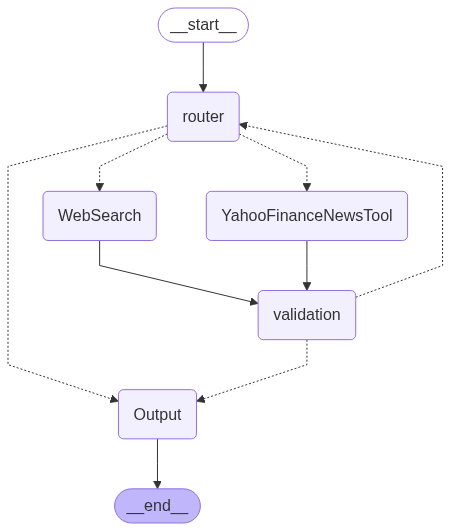

In [14]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))


In [15]:
#graph.invoke({"question": "AAPL"})  # For finance
# print("Invoking graph with 'What is the tallest building?'...")
result_web = graph.invoke({"question": "What is capital of India?"})
# print(f"Web Search Result: {result_web}")  # For web search

What is capital of India?
WebSearch
What is capital of India?
WebSearch
What is capital of India?
WebSearch


InvalidUpdateError: Expected dict, got Output
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_GRAPH_NODE_RETURN_VALUE